# Plotting Morris Index Results

In [32]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.dates as mdates

In [33]:
# Import data
ages = ['UNDER5', 'AGE517', 'AGE1829', 'AGE4049', 'AGE3039', 'AGE5064', 'AGE6574', 'AGE75PLUS']
morris = 'figures_morris'

data = []
for i in range(len(ages)):
    x = pd.read_csv('./results/' + ages[i] + '/' + morris + '/Morris.csv')
    data.append(x)
     
age_total = []
# Age 
for i in range(len(ages)):
    age_total.append(data[i][data[i].Feature == ages[i]])

In [34]:
# Function for formatter
class OOMFormatter(mpl.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        mpl.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
            self.format = r'$\mathdefault{%s}$' % self.format

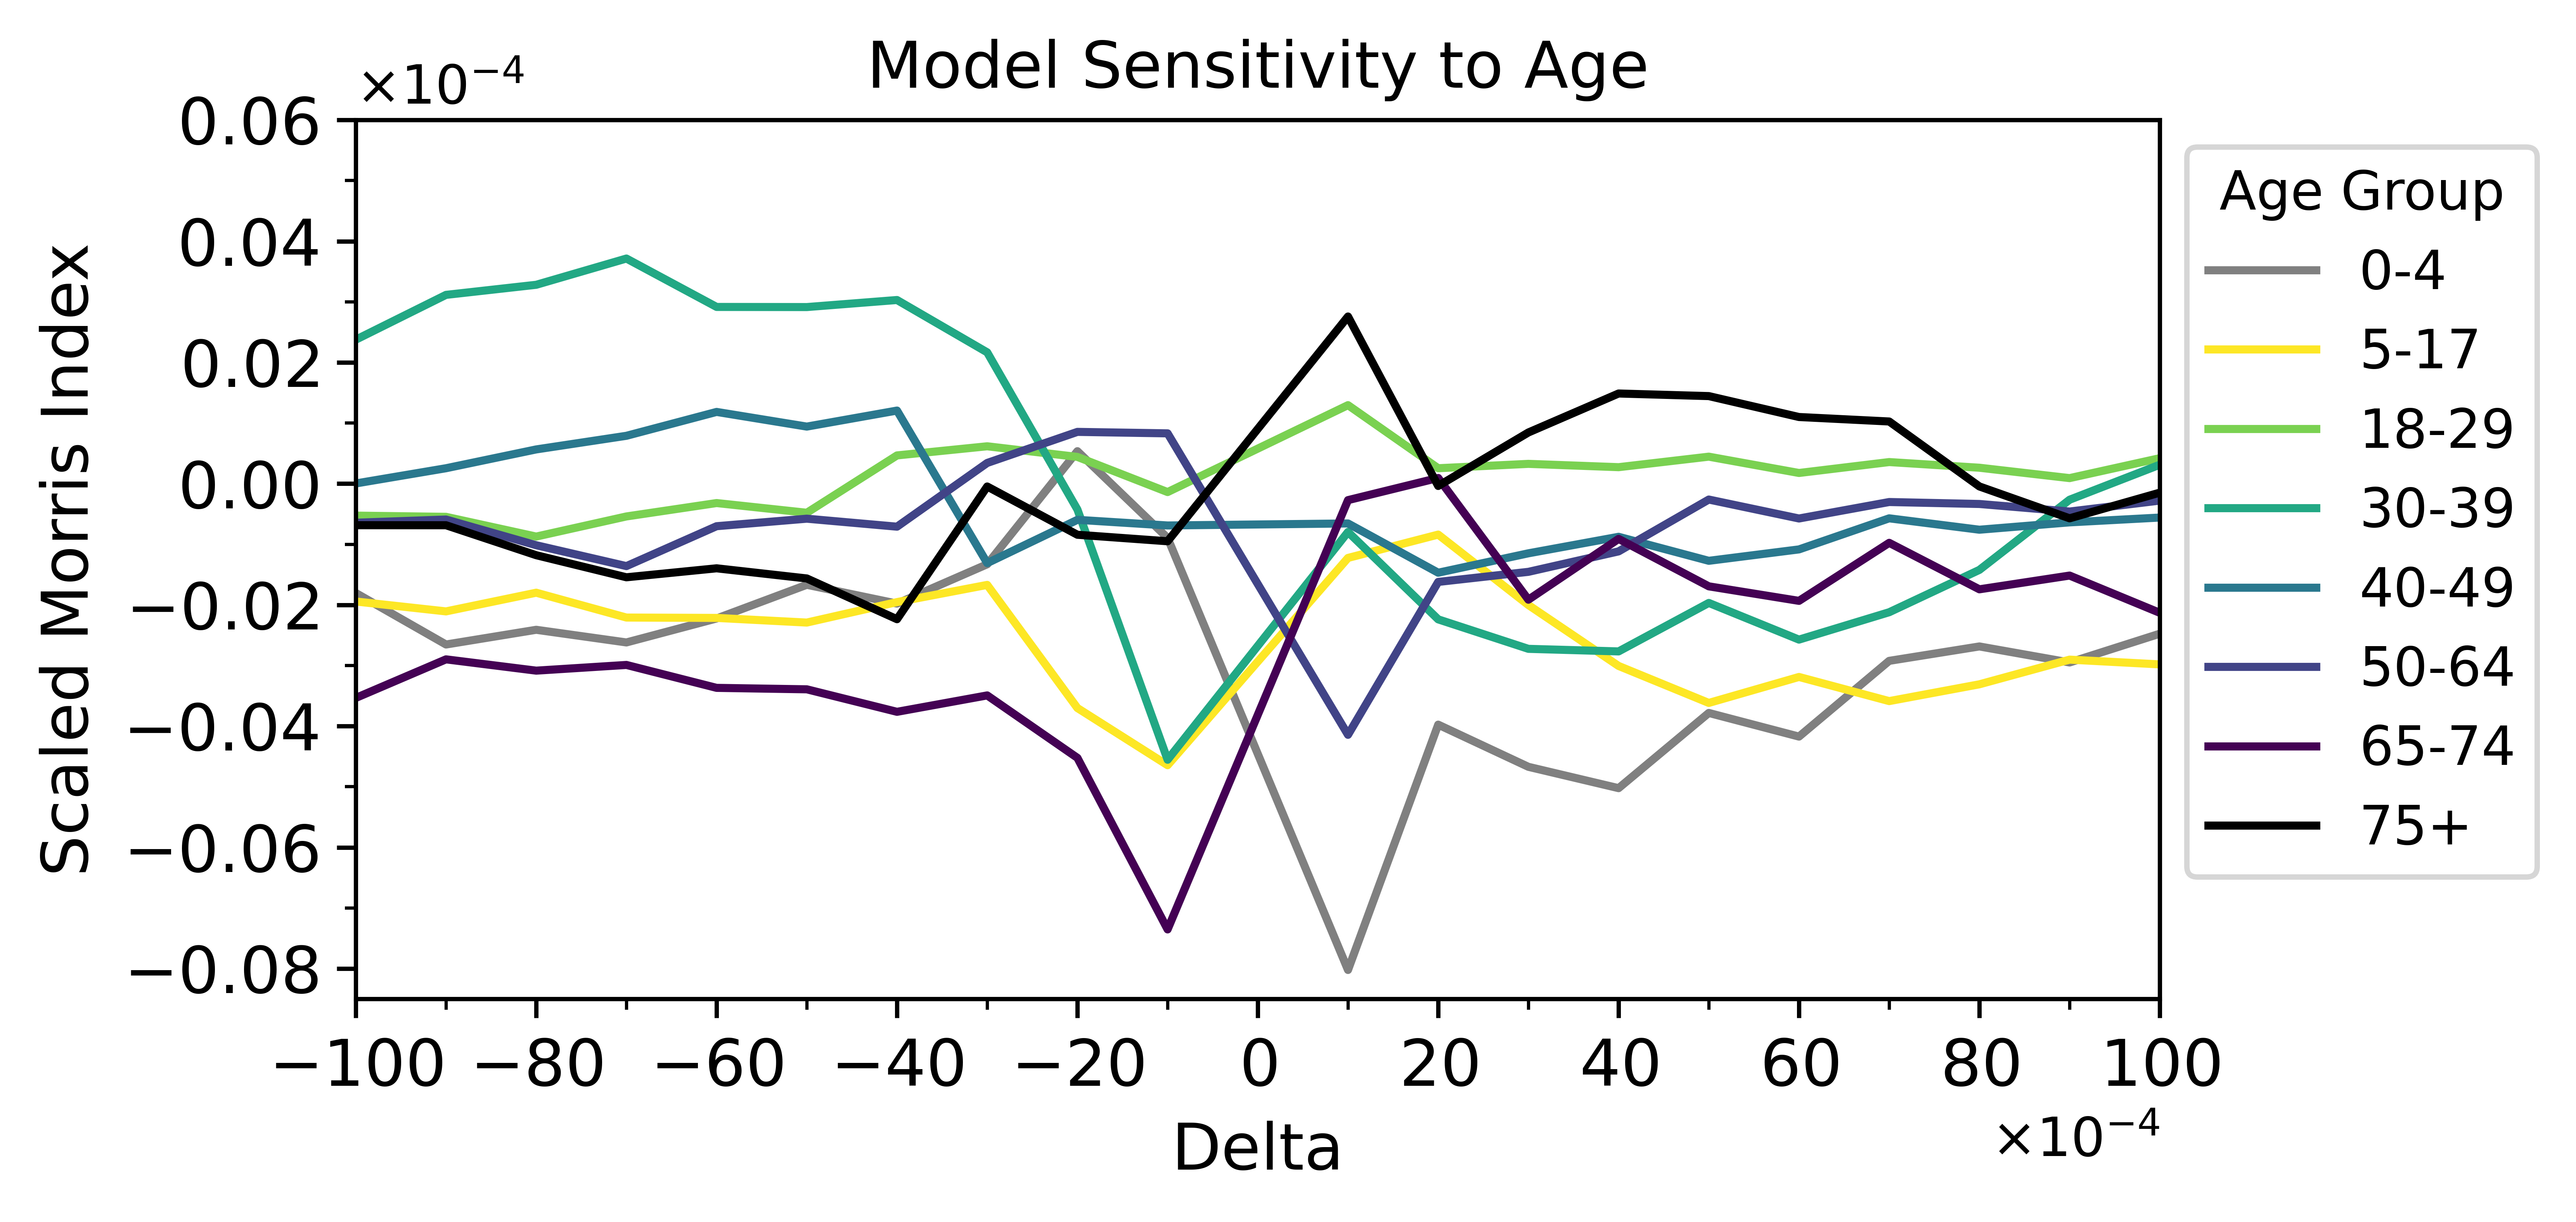

In [35]:
# Plot
mpl.rcParams['figure.dpi'] = 1000
fig, ax = plt.subplots(nrows=1, ncols=1, facecolor='w', sharey=True, figsize=(6, 3))
label = ['0-4', '5-17', '18-29', '30-39', '40-49', '50-64', '65-74', '75+']
color = ['gray', '#fde725', '#7ad151', '#22a884', '#2a788e', '#414487', '#440154', 'black']

# plot the same data on both axes
for i in range(len(ages)):
    plt.plot(age_total[i].Delta, age_total[i].Morris_sensitivity, '-', linewidth=1.5, label=label[i], color=color[i])
    
# Scale axes
ax.yaxis.set_major_formatter(OOMFormatter(-4, "%1.2f"))
ax.ticklabel_format(axis='y', style='sci', scilimits=(-4,-4))   
ax.xaxis.set_major_formatter(OOMFormatter(-4, "%1.0f"))
ax.ticklabel_format(axis='x', style='sci', scilimits=(-4,-4))
ax.xaxis.get_offset_text().set_visible(True)

# Format plot
ax.set_xticks([-0.01 , -0.008, -0.006, -0.004,
               -0.002, 0, 0.002, 0.004, 0.006,
               0.008, 0.01 ])
ax.set_xlim(-0.01, 0.01)
ax.set_ylim(-0.085e-4, 0.06e-4)

# Minor ticks
ax.set_xticks([-90e-4, -70e-4, -50e-4, -30e-4, -10e-4, 10e-4, 30e-4, 50e-4, 70e-4, 90e-4], minor=True)
ax.set_yticks([-0.08e-4, -0.06e-4, -0.04e-4, -0.02e-4, 0, 0.02e-4, 0.04e-4, 0.06e-4], minor=False)
ax.set_yticks([-0.07e-4, -0.05e-4, -0.03e-4, -0.01e-4, 0, 0.01e-4, 0.03e-4, 0.05e-4], minor=True)
ax.tick_params(axis='both', which='major', labelsize=12)

# Add labels
plt.ylabel('Scaled Morris Index', size=12)
plt.xlabel('Delta', size=12)
plt.title('Model Sensitivity to Age', size=12)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', title='Age Group')
plt.savefig('fig1.png', bbox_inches='tight')
plt.show()

# Obtaining Final Ranking

In [36]:
for i in range(0, len(ages)):
    data[i].Delta = round(data[i].Delta, 3)

In [37]:
deltas = list(data[0].Delta.unique())

In [38]:
ranking = pd.DataFrame(np.zeros(len(ages)))
ranking = ranking.reindex(index = ['0 - 4 Years','5 - 17 Years','18 - 29 Years', 
                                   '30 - 39 Years', '40 - 49 Years', 
                                   '50 - 64 Years', '65 - 74 Years', '75+ Years'])
for j in range(0, 20): 
    one = []
    for i in range(0, len(ages)):
        x = data[i][(data[i]['Delta'] == deltas[j])
                & (data[i]['Feature'] != 'VaccinationFull')]['Morris_sensitivity']
        one.append(x.values[0])
    ranking.insert(j, str(deltas[j]), one, True)
    
ranking = ranking.drop(0, axis=1)

In [39]:
for i in ranking.columns: 
    ranking[i] = ranking[i].rank(ascending=True)

In [40]:
ranking['mean_rows'] = ranking.mean(axis = 1)

In [41]:
colors = "Blues"
ranking[['mean_rows']].style.background_gradient(colors, subset=['mean_rows'])\
       .format({'mean_rows': '{:.2f}'})

,mean_rows
0 - 4 Years,2.25
5 - 17 Years,2.40
18 - 29 Years,6.80
30 - 39 Years,5.50
40 - 49 Years,5.60
50 - 64 Years,5.30
65 - 74 Years,2.65
75+ Years,5.50


# Preparation of Ground Truth Data for COVID-19 Infection Rates by Age Subgroup

# Cases by Age
https://data.cdc.gov/Public-Health-Surveillance/COVID-19-Weekly-Cases-and-Deaths-by-Age-Race-Ethni/hrdz-jaxc

In [42]:
# Import data from csv
data = pd.read_csv('Ground Truth/COVID-19_Weekly_Cases_and_Deaths_by_Age__Race_Ethnicity__and_Sex.csv')

In [43]:
# Select all U.S. jurisdictions, age groups, sexes, races/ethnicities
data = data[data.jurisdiction == 'US']
data = data[data.age_group != 'Overall']
data = data[data.sex == 'Overall']
data = data[data.race_ethnicity_combined == 'Overall']
data = data.drop(columns=['jurisdiction', 'sex', 'race_ethnicity_combined', \
                          'deaths', 'death_rate_per_100k', 'case_rate_per_100k'])

In [44]:
# Convert end_of_week column to DateTime
data['end_of_week'] = pd.to_datetime(data['end_of_week'])
data = data.sort_values(by=['end_of_week', 'age_group'])
data = data.reset_index().drop(columns=['index'])

In [45]:
# Select date range (end_of_week = 3/7/2020 to end_of_week = 11/27/2021)
data = data.iloc[0:910, :]

In [46]:
# Prepare data for plotting
x = data.end_of_week.unique()
y1 = data[data.age_group == '0 - 4 Years'].cases
y2 = data[data.age_group == '5 - 11 Years'].cases.values + \
     data[data.age_group == '12 - 15 Years'].cases.values + \
     data[data.age_group == '16 - 17 Years'].cases.values 
y3 = data[data.age_group == '18 - 29 Years'].cases
y4 = data[data.age_group == '30 - 39 Years'].cases
y5 = data[data.age_group == '40 - 49 Years'].cases
y6 = data[data.age_group == '50 - 64 Years'].cases
y7 = data[data.age_group == '65 - 74 Years'].cases
y8 = data[data.age_group == '75+ Years'].cases

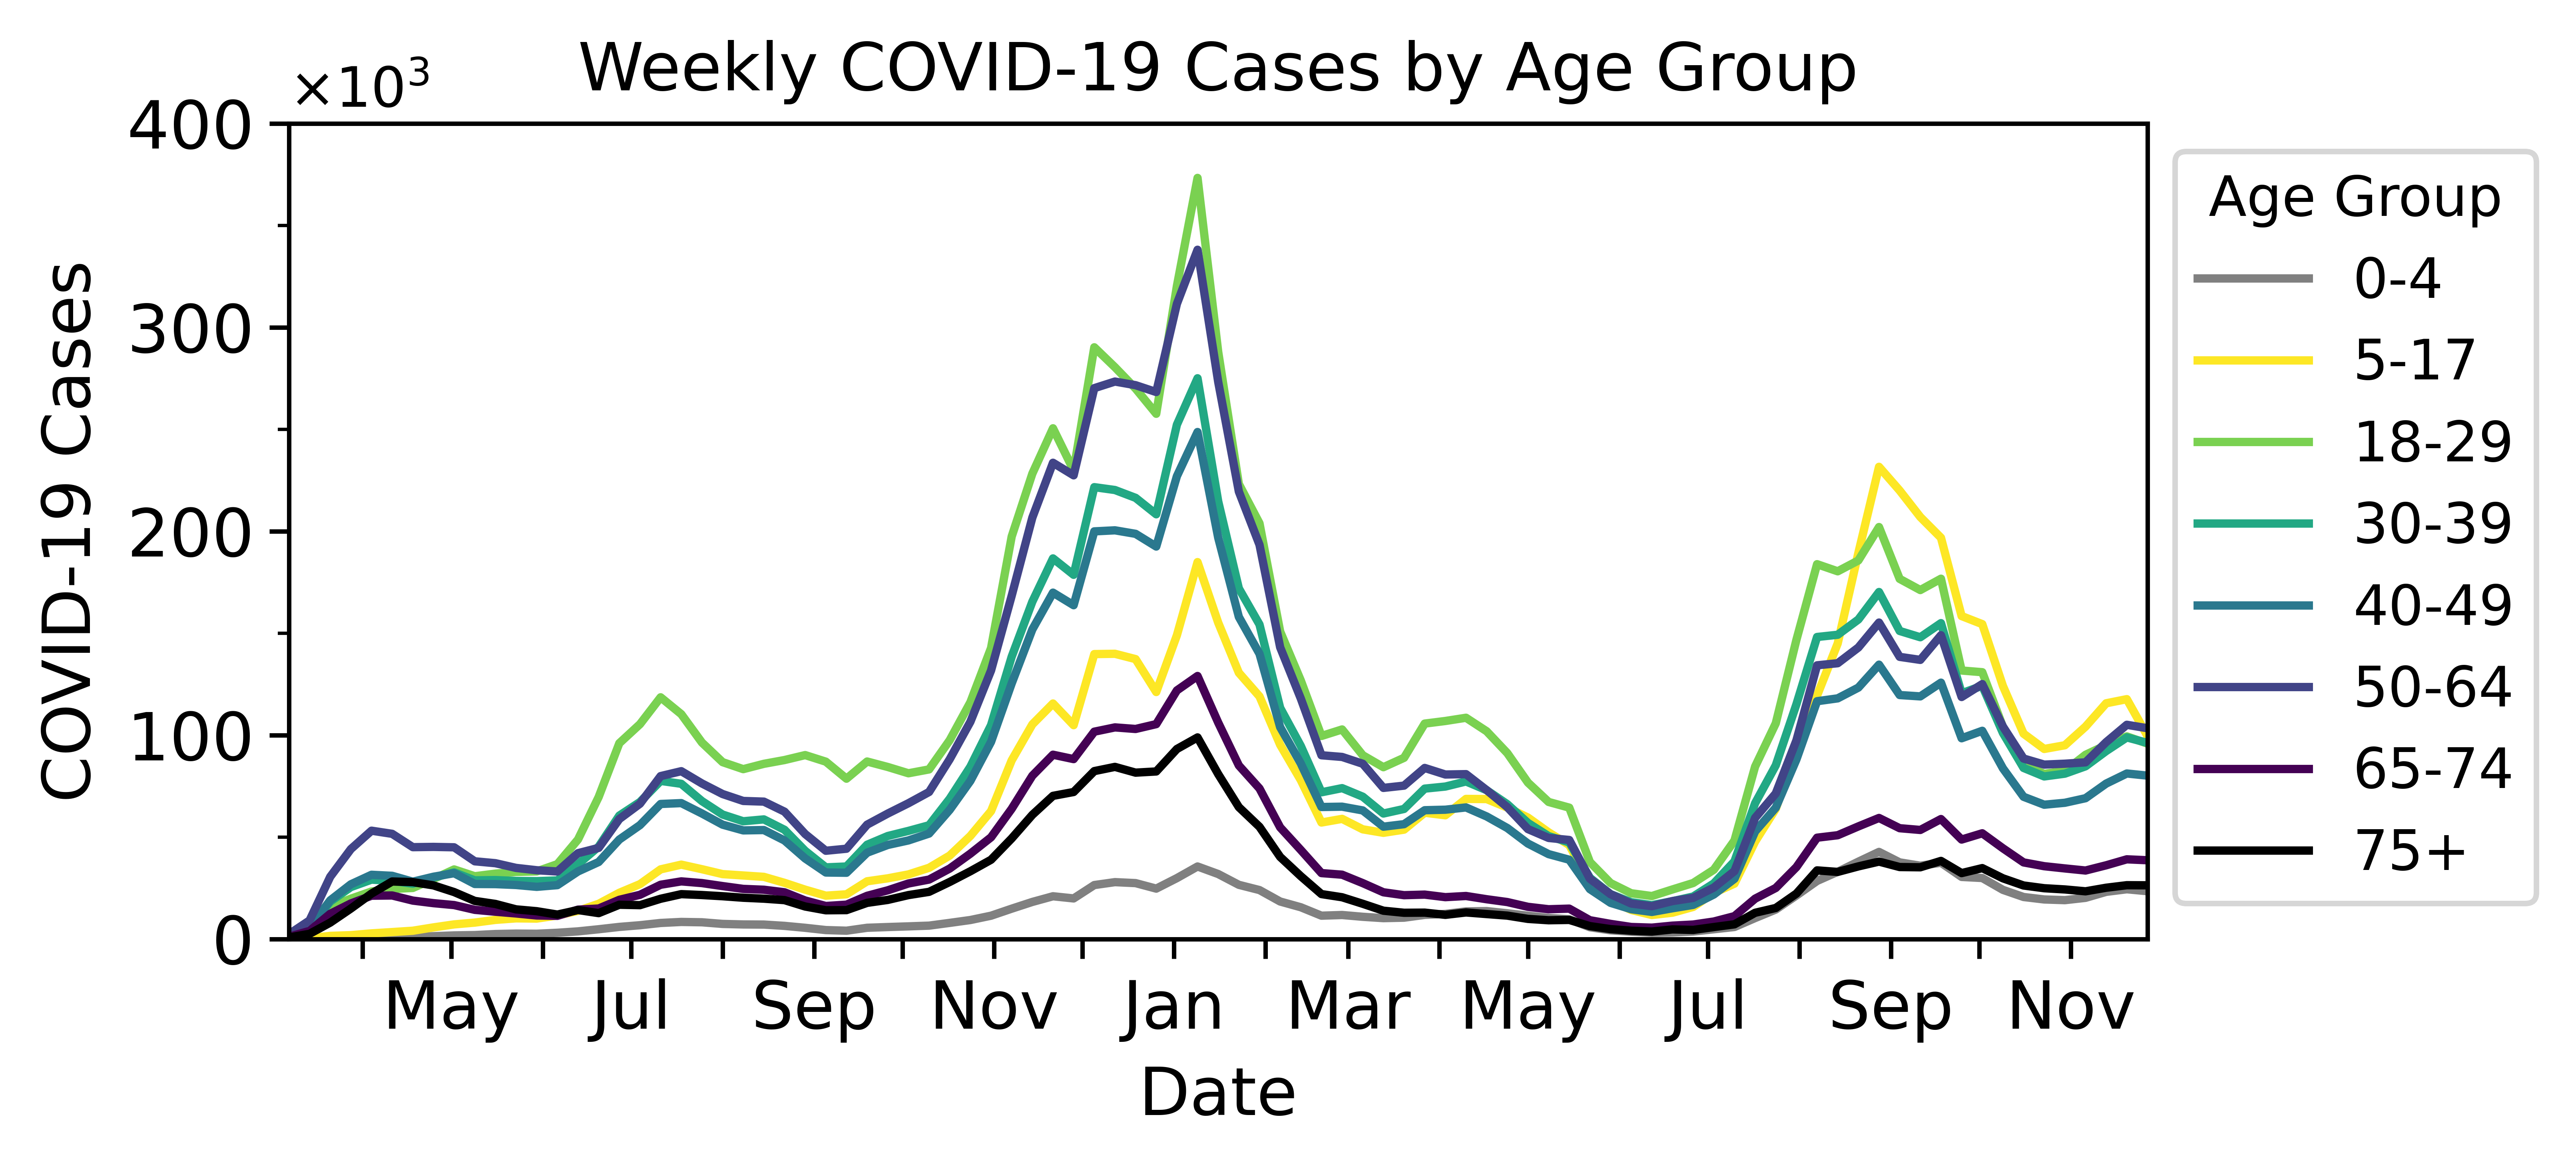

In [47]:
mpl.rcParams['figure.dpi'] = 1000
fig, ax = plt.subplots(nrows=1, ncols=1, facecolor='w', sharey=True, figsize=(6, 3))

# Plot 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
color = ['gray', '#fde725', '#7ad151', '#22a884', '#2a788e', '#414487', '#440154', 'black']
label = ['0-4', '5-17', '18-29', '30-39', '40-49', '50-64', '65-74', '75+']
plt.plot(x, y1, color = color[0], label=label[0])
plt.plot(x, y2, color = color[1], label=label[1])
plt.plot(x, y3, color = color[2], label=label[2])
plt.plot(x, y4, color = color[3], label=label[3])
plt.plot(x, y5, color = color[4], label=label[4])
plt.plot(x, y6, color = color[5], label=label[5])
plt.plot(x, y7, color = color[6], label=label[6])
plt.plot(x, y8, color = color[7], label=label[7])

# Format axis 
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.figure.autofmt_xdate(rotation=0, ha='center');
ax.tick_params(labelsize=12, which='both')

# Format labels
ax.yaxis.set_major_formatter(OOMFormatter(3, "%5.0f"))
ax.ticklabel_format(axis='y', style='sci')   
ax.set_yticks([50e3, 100e3, 150e3, 200e3, 250e3, 300e3, 350e3], minor=True)
ax.set_xlim('2020-03-07T00:00:00.000000000', '2021-11-27T00:00:00.000000000')
ax.set_ylim(0, 400e3)

for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

# Add labels
plt.ylabel('COVID-19 Cases', size=12)
plt.xlabel('Date', size=12)
plt.title('Weekly COVID-19 Cases by Age Group', size=12)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', title='Age Group')
plt.savefig('fig2.png', bbox_inches='tight')
plt.show()

In [48]:
# Find sum of all cases for each age group during time period
data = data.groupby(by=["age_group"]).sum('numeric_only').sort_index()

In [49]:
# Create 5-17 age group
data.loc['5 - 17 Years'] = data[data.index == '5 - 11 Years'].cases[0] + \
                           data[data.index == '12 - 15 Years'].cases[0] + \
                           data[data.index == '16 - 17 Years'].cases[0] 

# Drop unneeded age groups
data = data.drop(['5 - 11 Years', '12 - 15 Years',  '16 - 17 Years']).sort_index()

# Population by Age
## These data are estimates for April 1, 2020
https://www.census.gov/data/tables/time-series/demo/popest/2020s-national-detail.html

In [50]:
# Import data from csv
pop = pd.read_csv('Ground Truth/nc-est2021-agesex-res.csv', usecols=['SEX', 'AGE', 'ESTIMATESBASE2020'])
pop = pop[pop.SEX == 0]
pop = pop.rename(columns={'ESTIMATESBASE2020': 'population', 'AGE': 'age'})
pop = pop.drop(columns=['SEX'])

In [51]:
# Create age groups
age_04 = pop.iloc[0:5].population.values.sum()
age_517 = pop.iloc[5:18].population.values.sum()
age_1829 = pop.iloc[18:30].population.values.sum()
age_3039 = pop.iloc[30:40].population.values.sum()
age_4049 = pop.iloc[40:50].population.values.sum()
age_5064 = pop.iloc[50:65].population.values.sum()
age_6574 = pop.iloc[65:75].population.values.sum()
age_75plus = pop.iloc[75:101].population.values.sum()
pops = [age_04, age_517, age_1829, age_3039, age_4049, age_5064, age_6574, age_75plus]

In [52]:
# Using DataFrame.insert() to add a column
data.insert(1, "population", pops, True)

In [53]:
# Final data frame
data = data.reindex(index = ['0 - 4 Years','5 - 17 Years','18 - 29 Years', '30 - 39 Years', '40 - 49 Years', \
                             '50 - 64 Years', '65 - 74 Years', '75+ Years'])
data

,cases,population
age_group,,
0 - 4 Years,1249223,19392551
5 - 17 Years,6184296,41003731
18 - 29 Years,10018923,54992661
30 - 39 Years,7760789,53013409
40 - 49 Years,6767348,45034182
50 - 64 Years,8820765,63876118
65 - 74 Years,3289094,32346340
75+ Years,2505606,21790289


# Calculate Ranking for each Age Group

In [54]:
# Calculate percentage of age infected (total pop)
percent_pop = (data.cases.values / data.population.values.sum()) * 100
data.insert(2, "% of pop", np.round(percent_pop, 2), True)

# Calculate percentage of age infected 
percent_group = (data.cases / data.population).values * 100
data.insert(3, "% of group", np.round(percent_group, 2), True)

# Add Morris ranking
morris = ranking['mean_rows']
data.insert(4, 'morris', morris, True)

In [55]:
data = data.drop(columns=['cases', 'population'])

In [56]:
data = data.rename({'% of pop': 'Population',
                    '% of group': 'Group',
                    'morris': 'Morris'}, axis=1) 

In [57]:
data.index.name = 'Age Group'

In [58]:
data['Population'] = data['Population'].rank(ascending=True)

In [59]:
data['Group'] = data['Group'].rank(ascending=True)

In [60]:
data['Morris'] = data['Morris'].rank(ascending=True)

In [61]:
# Add Morris ranking
change = abs(data['Population'] - data['Morris'])
data.insert(3, '|Morris - Population|', change, True)

change2 = abs(data['Group'] - data['Morris'])
data.insert(4, '|Morris - Group|', change2, True)

In [62]:
data.style\
    .format({'Population': '{:.0f}', 'Group': '{:.0f}', 'Morris': '{:.0f}',
             '|Morris - Population|': '{:.0f}', '|Morris - Group|': '{:.0f}'})\
    .set_properties( **{'text-align': 'center'})

,Population,Group,Morris,|Morris - Population|,|Morris - Group|
Age Group,,,,,
0 - 4 Years,1,1,1,0,0
5 - 17 Years,4,7,2,2,5
18 - 29 Years,8,8,8,0,0
30 - 39 Years,6,5,6,0,0
40 - 49 Years,5,6,7,2,1
50 - 64 Years,7,4,4,3,0
65 - 74 Years,3,2,3,0,1
75+ Years,2,3,6,4,2
